In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
chemin_fichier_excel = "C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\SX5Edec2021.xlsx"

df = pd.read_excel(chemin_fichier_excel, parse_dates=['Dates'])
df = df.rename(columns={'SX5E Index': 'Cours'})

In [26]:
#rescaling de la vol avec la méthode abordée dans l'article "sense, non sense and s&p500" pour voir si ça marche mieux 

#on rajoute une ligne avec les rendements journaliers Xt

df['Rendements journaliers Xt en %']=df['Cours'].pct_change() * 100
#on supprime la 1e ligne car le rdt journalier vaut NaN
df = df.iloc[1:]
df = df.reset_index(drop=True)

#Pour faciliter les calculs, on définit le vecteur contenant les rendements non rescalés:
returns=df['Rendements journaliers Xt en %'].to_numpy()
print(returns)


#on définit le vecteur contenant les estimateurs de notre vol:
volestimate = np.empty(len(df))

#on définit le vecteur contenant les rendements rescalés
rescaledreturns = np.empty(len(df))

#on calcule l'estimateur de notre vol initiale, appelons-le v0: 
volestimate[0]=np.sqrt(np.sum(np.square(returns))/len(returns))
rescaledreturns[0]=returns[0]/volestimate[0]

                                
#on définit la cut-off constant K, qui permet d'éviter à des valeurs de rendements journaliers extremes exceptionnels de trop
#impacter notre estimateur de volatilité. On teste avec K=4 comme dans l'article 
K=4

#on définit le paramètre de pondération exponentielle BW, qui lisse notre estimateur de volatilité. On teste avec BW=0,025 comme
#dans l'article 
BW=0.025 ##pour une moyenne sur 40 jours 

for t in range(0,len(returns)-1):
    Y=max(-K*volestimate[t],min(K*volestimate[t],returns[t]))
    volestimate[t+1]=np.sqrt(BW*Y**2 +(1-BW)*volestimate[t]**2)
    rescaledreturns[t+1]=returns[t+1]/volestimate[t+1]


[ 1.02691396 -2.16044982  3.74277676 ...  0.55853805 -0.62848887
  0.51367265]


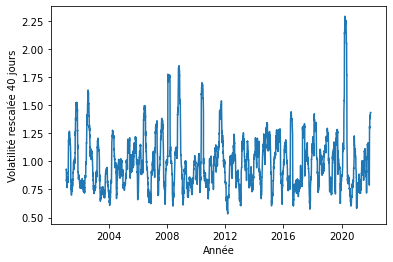

In [27]:
#puis on calcule la volatilité quotidienne à partir des rdts rescalés:

rescaledvol = np.empty(len(returns))

for t in range(40, len(returns)):
    returnmoyen40 = np.mean(rescaledreturns[t-40:t]) 
    rescaledvol[t]=np.sqrt(np.mean((rescaledreturns[t-40:t]-returnmoyen40)**2)) 
    
for t in range(0,39):
    rescaledvol[t]=0

#on ajoute au dataframe la colonne vol rescalée 40 jours, et les rendements recalés
df['rendements rescalés 2e méthode']=rescaledreturns
df['vol rescalée 40 jours']=rescaledvol

# Tracer la volatilité sur 40 jours
plt.plot(df['Dates'].iloc[40:], df['vol rescalée 40 jours'].iloc[40:], label='Volatilité rescalée 40 jours')
plt.xlabel('Année')
plt.ylabel('Volatilité rescalée 40 jours')
plt.show()

#il faut peut être diviser la vol par 10 pour avoir les mêmes ordres de grandeur que sans tweaker les données 
#le résultat a l'air correct aussi mais plus d'amplitude que avec la 1e méthode. Il faudrait tester avec le BW adapté à 60 jours 

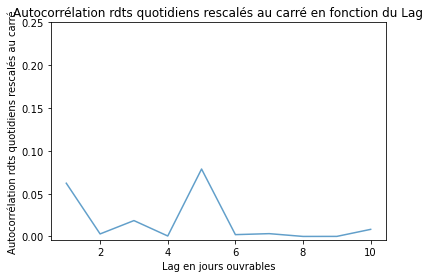

In [28]:
# on trace l'autocorrélation des rendements au carré avec la 2e méthode 

max_lag = 10  
autocorr_squared2 = [(df['rendements rescalés 2e méthode'].autocorr(lag=i)**2)*100 for i in range(1, max_lag + 1)]


plt.plot(range(1, max_lag + 1), autocorr_squared2, marker='', linestyle='-', color='#1f77b4', alpha=0.7)

plt.yticks(np.arange(0, 0.3, step=0.05))

plt.title('Autocorrélation rdts quotidiens rescalés au carré en fonction du Lag')
plt.xlabel('Lag en jours ouvrables')
plt.ylabel('Autocorrélation rdts quotidiens rescalés au carré')
plt.grid(False)

plt.show()

# c'est moins pire que sans tweaker les données mais c'est pas constant non plus. Si on zoome on voit que c'est pas constant du tout

0.003191221544503625 1.0391166759926358


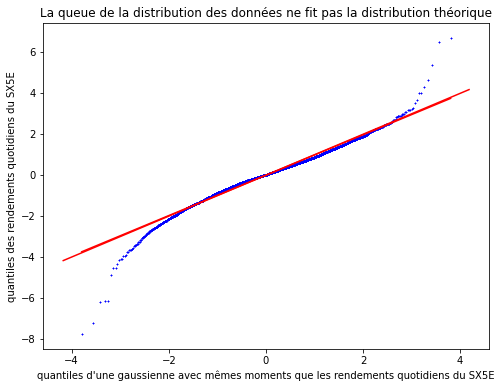

In [39]:
#on trace le qq plot après rescaling 2e méthode


from scipy.stats import probplot

#on calcule les moments 
murescalé2 = np.mean(df['rendements rescalés 2e méthode'])
sigmarescalé2 = np.std(df['rendements rescalés 2e méthode'])

print(murescalé2,sigmarescalé2)
fig, ax = plt.subplots(figsize=(8, 6))
probplot(df['rendements rescalés 2e méthode'], dist='norm', sparams=(murescalé2,sigmarescalé2),plot=ax)
plt.plot(plt.xlim(),plt.xlim(),color='red', label='y=x')
plt.xlabel("quantiles d'une gaussienne avec mêmes moments que les rendements quotidiens du SX5E")
plt.ylabel("quantiles des rendements quotidiens du SX5E")
plt.title('La queue de la distribution des données ne fit pas la distribution théorique')

ax.get_lines()[0].set_marker('+')
ax.get_lines()[0].set_markersize(2)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[0].set_markeredgecolor('blue')

#ça fit tjrs aussi mal sur la queue mais au moins ça fit mieux sur [-2.5;2.5]